# Recurrent neural networks

## Motivation

Up to now we used neural networks to learn functions that predicted a desired output $y$ based on an input vector $x$. We have assumed that $x$ has a constant size, such as an image of a given resolution.

In contrast, recurrent networks can be applied to sequences of different length.

Consider the problem of computing the parity checksum of a sequence of bits. Traditional neural networks that we know can not be applied to bit sequences of arbitrary length, yet a program which reads in the sequence bit-by-bit is very easy to write. 

Another motivating example is sequence generation, such as generating text or music. Again, normal neural networks that take a fixed input size are not directly applicable to whole sequences.

## Autoregressive models

An autoregressive model assumes, that the $i$-th element of a sequence depends only on a few preceding sequence elements. Lets first write the exact probability of observing a sequence $\mathbf{Y} = [Y_1, Y_2, \ldots, Y_m]$:

$$
    P(\mathbf{Y}) = P(Y_1)P(Y_2|Y_1)P(Y_3|Y_1, Y_2)\ldots P(Y_m|Y1,Y_2,\ldots,Y_{n-1})=\prod_i P(Y_i|Y_1,\ldots, Y_{i-1})
$$

The autoregressive model simply assumes that we can use only a finite history, that is:
$$
    P(Y_i|Y_1,\ldots, Y_{i-1}) \approx P(Y_i|Y_{i-n},\ldots, Y_{i-1})
$$

Autoregressive models are quite frequently used, because they are easy to implement - it is sufficient extract $n$ element long subsequences and learn a model that predicts the last element given the $n-1$ preceding ones. Thus autoregressive models reduce the sequence learning problem to the typicall supervised learning setup

### Examples

Autoregressive models are very popular, for instance:

1. Language models (that is models which tell how probable is a given utterance) are often expressed as $n$-gram models in which $P(Y_i|Y_{i-n},\ldots, Y_{i-1})$ is simply established by counting occurrences in a corpus of text.
2. The ARMA model used in timeseries prediction is expressed as:
  $$
        Y_t = \sum_{i=1}^{n}\alpha_i Y_{t-i} + \sum_{i=1}^k \Theta_i \epsilon_{t-i},
  $$
    where $\epsilon_i$ are assumed to be normally distributed noise variables.
    
## Models with a hidden state

Autoregressive models have a very short memory which limits their applicability. We can build a more powerfull model by introducing a sequence of hidden states $\mathbf{H} = [H_0, H_1, \ldots]$. We will assume that all history of a sequence can be captured by the state:

$$
    P(Y_i|Y_1,\ldots, Y_{i-1}) \approx P(Y_i|Y_{i-n}, H_{i-1})
$$


### Recurrent neural networks

Recurrent neural networks are a generalization of the model with the hidden state. We will assume that there is an input sequence $\mathbb{X}$. The network will process the elements of $\mathbb{X}$  one at a time producing a sequence of hidden states and a sequence of outputs. We will train the model by specifying the desired outputs. We will be able to supervise the model at each step (which is common e.g. in sequence generators which are taught to predict the next sequence element) or only at the end (which can be used in the parity computing network).

Define a recurrent computation:

$$
\begin{align}
    H_t &= f(X_t, H_{t-1}) \\
    Y_t &= g(X_t, H_t)
\end{align}
$$

In a recurrent neural network the function $f$ and $g$ are implemented as multilayer neural networks.

### Backpropagation through time

The last question is how to train such a recurrent network? The typicall approach is to *unroll the network in time*, then compute the loss and backpropagate it over the time steps. Gradient backpropagation algorithm works, thus in principle training doesn't require new skill. Hovewer, the unrolled network is very deep (its depth equals to the number of time steps!) and quite pathological, because the same weight matrices are reused at all times. For this reasons recurrent networks suffer from two problems:

1. Gradient vanishing, when the gradient drops to zero and no training is possible.
2. Gradient explosion, when the gradient grows really quickly and a single step can destroy the network.

The two problems are related. Consider the following recurrency:

$$
    H_t = W_{hh}H_{t-1} = (W_{hh})^t H_0
$$

Suppose $H_0$ is an eigenvector - then depending on the magnitude of the associated eigenvalue the hidden state will either exponentially grow or decay! Of course, the network will typically have sone nonlinearities that will prevent the explosion of the hiden state. However, the backpropagation computation is linear (because all nonlinearities are linerized at the operating point). Thus the gradient is very prone to explode or implode!

### Solutions to gradient pathologies

#### Echo-state networks
The first solution to training recurrent networks is... not to train the recurrent connections! This approach is taken in the *echo state networks* which perform the following computation:

$$
    \begin{align}
        H_t &= \tanh(W_{xh}X_t + W_{hh} H_{t-1} + b_h) \\
        O_t &= W_{xo}X_t + W_{ho}H_T + b_o
    \end{align}
$$

The training procedure is as follows:

1. Randomly sample $W_{hh}$ and $W_{xh}$.
2. Rescale $W_{hh}$ to have the largest eigenvalue close to 1
3. Fit the $W_{xo}$ and $W{ho}$ using the closed-form formula for least squares
4. Since steps 1.-3. are super-fast, repeat them multiple times with different scaling of $W_{hh}$ and $W_{xh}$.

Because $W_{hh}$ has the largest eigenvalue sligtly less than 1, the hidden states oscillate and decay slowly. This creates "echoes" of previous inputs that reverberate in the network.

#### Gradient clipping

Gradient explosion can be prevented by rescaling gradients that are larger than a specified threshold. You can either clip individual components of the gradient, or rescale the whole gradient.

#### LSTM cells

LSTM's are important! They contributed a lot to recent sucesses of recurrent neural networks!

For introduction and intuitions please see http://colah.github.io/posts/2015-08-Understanding-LSTMs/

For more in-depth analysis please look at: http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf and http://arxiv.org/pdf/1503.04069v1.pdf

The core idea of LSTM is to introduce multiplicative *gates* that enable long pathways of nearly constant values/gradients of memory cells that we will denote $c$. The core equations of LSTM are:

$$
\begin{align}
    i_t &= \sigma(W_{xi}X_t + W_{hi}H_{t-1} + W_{ci}c_{t-1} + b_i) \\
    f_t &= \sigma(W_{xf}X_t + W_{hf}H_{t-1} + W_{cf}c_{t-1} + b_f) \\
    c_t &= f_t c_{t-1} + i_t\tanh(W_{xc}X_t + W_{hc}H_{t-1} + b_i) \\
    o_t &= \sigma(W_{xo}X_t + W_{ho}H_{t-1} + W_{co}c_{t} + b_o) \\
    H_t &= o_t \tanh(c_t)
\end{align}
$$

#### Multilayer and bi-directional LSTM networks

It is possible to stack several LSTM layers (see the code below). Likewise, it is common to invert the input sequence to run the LSTM backward in time. Then the forward and backward hidden states give a summary of the sequence around a certain element.

### Tricks of the trade

1. Use train rules that allow per-parameter learnign rates (e.g. RMSProp)
2. Monitor gradient magnitude!
3. Initialization is important:
    - it often helps to orthogonalize recurent weights and rescale to have the largest eigenvalue close to 1. This is similar to hidden-to-hidden weights in echo state networks
    - forget-gate biases in LSTMs are ofetn initialized to 1 instead of 0. This enhances information retention at the beginning of training
4. Learning interdependencies across many time steps is difficult. If possible train on short (or othervise simple) sequences first (this is often called "curriculum learning")

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
debug = True # global var to control debugging
CUDA = False # Cuda may be slower, as we are computing very small networks

In [3]:
import os

import pandas as pd

In [4]:
import torch
import torch.tensor as T

from torch.nn.parameter import Parameter

from torch.nn import functional as F

def V(np_var):
    t = torch.from_numpy(np_var)
    if CUDA:
        t = t.cuda()
    return t

## RNN implementation in PyTorch

Please note that PyTorch has RNN implementations (http://pytorch.org/docs/master/nn.html#recurrent-layers). The goal of this notebook is to demonstrate the basics of RNNs. For future projects please use the built-in mudules. They have more features, and are faster (they use the CuDNN library supplied by Nvidia).

**Attention**: through the code we will assume that the 0-th axis refers to time and that the 1-st axis refers to individual examples inside a minibatch. (This way in a C-major memory layout individual time steps occupy contiguous regions in memory)

In [5]:
class SimpleRNNCell(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, activation=torch.nn.Tanh(), **kwargs):
        super(SimpleRNNCell, self).__init__(**kwargs)
        
        self.activation = activation
        # Input to hidden
        self.Wxh = Parameter(torch.Tensor(in_dim, hidden_dim))
        
        # Hidden to hidden
        self.Whh = Parameter(torch.Tensor(hidden_dim, hidden_dim))
        
        # Hidden bias
        self.bh = Parameter(torch.Tensor(hidden_dim))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Whh.size(1))
        self.Wxh.data.uniform_(-stdv, stdv)
        self.Whh.data.uniform_(-stdv, stdv)
        self.bh.data.zero_()
    
    def forward(self, input, h):
        pre_act = (
            self.bh +
            torch.matmul(input, self.Wxh) + 
            torch.matmul(h, self.Whh)
        )
        return self.activation(pre_act)
            

class RNN(torch.nn.Module):
    def __init__(self, cell, **kwargs):
        super(RNN, self).__init__(**kwargs)
        self.cell = cell

    def forward(self, input, hidden):
        cell = self.cell
        output = []
        for i in range(input.size(0)):
            hidden = cell(input[i], hidden)
            # hack to handle LSTM
            output.append(hidden[0] if isinstance(hidden, tuple) else hidden)

        output = torch.cat(output, 0).view(input.size(0), *output[0].size())

        return hidden, output

# The parity task

Here we solve the bit parity problem. Note that we will need at least two hidden neurons, because the network has to solve a XOR problem at each step.

In [6]:
def gen_parity_examples(time_steps, batch_size):
    X = (numpy.random.rand(time_steps, batch_size, 1)>0.5).astype('float32')
    Y = X.cumsum(0) % 2
    return X, Y


Xp, Yp = gen_parity_examples(18, 1)
print('X.T:', Xp.reshape(Xp.shape[:-1]).T, '\nY.T:', Yp.reshape(Yp.shape[:-1]).T)

X.T: [[0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.]] 
Y.T: [[0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]]


In [7]:
# The input variable - a 3D tensor with axes:
# time x batch_size x num_features

hidden_dim = 2
test_net = RNN(SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim))

if CUDA:
    test_net.cuda()

h0 = np.zeros((1, hidden_dim), dtype='float32')  # 1 sequence in batch, 1 hidden dim
hn, O = test_net(V(Xp), V(h0))

print('O', O.squeeze())

O tensor([[ 0.0000,  0.0000],
        [ 0.4527,  0.0761],
        [ 0.3105,  0.2455],
        [-0.1408,  0.2362],
        [ 0.4648,  0.1829],
        [ 0.2931,  0.3103],
        [ 0.3304,  0.3388],
        [ 0.3152,  0.3636],
        [ 0.3168,  0.3734],
        [-0.1605,  0.3119],
        [ 0.0115,  0.1495],
        [-0.0250,  0.0966],
        [-0.0050,  0.0535],
        [ 0.4481,  0.1080],
        [-0.1682,  0.1906],
        [ 0.4772,  0.1477],
        [-0.1834,  0.2222],
        [ 0.0320,  0.0878]], grad_fn=<SqueezeBackward0>)


In [8]:
class ParityNet(torch.nn.Module):
    def __init__(self, hidden_dim, **kwargs):
        super(ParityNet, self).__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.rnn = RNN(
            cell=SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim,
                               activation=torch.nn.Sigmoid()))
        self.linear = torch.nn.Linear(in_features=1 + hidden_dim,
                                      out_features=1)
        
    def forward(self, inputs):
        h0 = np.zeros((inputs.size(1), self.hidden_dim),
                      dtype='float32')
        _, H = self.rnn(inputs, V(h0))
        # concatenate inputs and hidden states
        inputs_and_H = torch.cat((inputs, H), dim=2)
        return torch.sigmoid(self.linear(inputs_and_H))

In [9]:
parity_net = ParityNet(hidden_dim=2)

if CUDA:
    parity_net.cuda()

#
# Design the net to solve parity
#
parity_net.rnn.cell.Wxh.data[...
    ] = torch.FloatTensor([[2000, 1000]])
parity_net.rnn.cell.Whh.data[...
    ] = torch.FloatTensor([[ 1000,  1000],
                           [-1000, -1000]])
parity_net.rnn.cell.bh.data[...
    ] = torch.FloatTensor([-500, -1500])

parity_net.linear.weight.data[...
    ] = torch.FloatTensor([[ 0],
                           [ 1000],
                           [-1000]]).transpose(0, 1)
parity_net.linear.bias.data[...
    ] = torch.FloatTensor([-500])
    
predictions = parity_net(V(Xp)).detach().cpu().numpy().squeeze()
print('        X: ', Xp.squeeze())
print('predicted: ', np.round(predictions))
print('        Y: ', Yp.squeeze())

        X:  [0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
predicted:  [0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
        Y:  [0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]


In [10]:
class Trainer(object):
    def __init__(self, network):
        # If full_supervision == True, supervice net outputs at all steps
        # if full_supervision == False, supervise net outputs at the last
        # step only
        self.full_supervision = True
        
        # When the total gradient is above this value, scale it down
        self.max_grad_norm = 1.0
        
        self.network = network
        
        # RMSprop stuff
        self.lrate = 1e-2
        self.RMSProp_dec_rate = 0.9
        self.RMSProp_epsilon = 1e-5
        device = 'cuda' if CUDA else 'cpu'
        self.gnorms = [torch.zeros(*p.size(), device=device)
                       for p in self.network.parameters()]
    
    def train_step(self, X, Y):
        X = V(X)
        Y = V(Y)
        net = self.network
        net.zero_grad()
        # predictions
        P = net(X)
        if self.full_supervision:
            loss = torch.mean((P - Y)**2)
        else:
            loss = torch.mean((P[-1] - Y[-1])**2)
        loss.backward()
        
        tot_gnorm = torch.FloatTensor((0.0,))
        if CUDA:
            tot_gnorm = tot_gnorm.cuda()
        # compute the norm of the gradient
        for p in net.parameters():
            tot_gnorm += torch.sum(p.grad.data**2)
        tot_gnorm = torch.sqrt(tot_gnorm)
        
        g_div = torch.max(torch.FloatTensor((self.max_grad_norm,)
                                           ).to(tot_gnorm.device), tot_gnorm)
        
        for i, p in enumerate(net.parameters()):
            g = p.grad.data / g_div
            #TODO: weight decay
            self.gnorms[i] *= self.RMSProp_dec_rate
            self.gnorms[i] += (1.0 - self.RMSProp_dec_rate) * g**2
            p.data -= self.lrate * g / torch.sqrt(self.gnorms[i] + self.RMSProp_epsilon)
        return dict(loss=loss.item(), grad_norm=tot_gnorm.item())

# Exploration of various problems with RNN training

In the following cell you can implement with various ways of providing supervision to the network (which one is easier to train - when the net recieves feedback after each step or whn it recieves feedback only at the end of training?), changing the gradient clipping and playing with a curriculum.

Notice the dynamics of training - at the beginning the network does very little. The, suddenly it notices the input-output relationship from which point training starts to progress very quickly.

In [11]:
CUDA = False

0 {'loss': 0.25897645950317383, 'grad_norm': 0.057599037885665894}
500 {'loss': 0.24749304354190826, 'grad_norm': 0.012723824009299278}
1000 {'loss': 0.2502225339412689, 'grad_norm': 0.005485456436872482}
1500 {'loss': 0.2508084177970886, 'grad_norm': 0.013454774394631386}
2000 {'loss': 0.25007960200309753, 'grad_norm': 0.013701658695936203}
2500 {'loss': 0.2512672543525696, 'grad_norm': 0.009249096736311913}
3000 {'loss': 0.24890010058879852, 'grad_norm': 0.004453734960407019}
3500 {'loss': 0.2506466805934906, 'grad_norm': 0.0073812720365822315}
4000 {'loss': 0.249660462141037, 'grad_norm': 0.012718112207949162}
4500 {'loss': 0.24977220594882965, 'grad_norm': 0.002243290888145566}
5000 {'loss': 0.24908404052257538, 'grad_norm': 0.04697431996464729}
5500 {'loss': 0.2490963339805603, 'grad_norm': 0.006662328727543354}
6000 {'loss': 0.24642178416252136, 'grad_norm': 0.004362808540463448}
6500 {'loss': 0.17913652956485748, 'grad_norm': 0.053108301013708115}
7000 {'loss': 0.237519651651382

Text(0.5, 0, 'iteration')

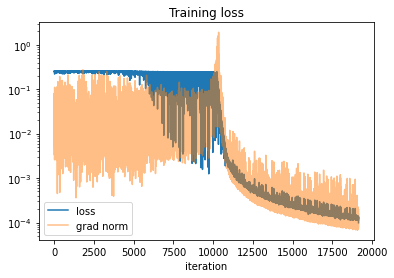

In [33]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()

parity_trainer = Trainer(parity_net)

# you can tweek the learning rate. 1e-2 worked best for me
parity_trainer.lrate = 1e-2

losses = []

# when set to 1 the net recieves an error signal after each step
# when set to 0 the net recieves an error signal only once at the end
parity_trainer.full_sup = True

# without full_supervision it takes long to train on long sequences
seq_len = 100

# this enables "curriculum learning" - we gradually train on 
# longer and longer sequences
#
max_seq_len = 100

for i in range(100000):
    Xp, Yp = gen_parity_examples(np.random.randint(1, seq_len), 10)
    ret = parity_trainer.train_step(Xp, Yp)
    losses.append(dict(iter=i, **ret))
    if ret['loss']<1e-4:
        seq_len += 10
        if seq_len>max_seq_len:
            break
        print(i, "Increasing seq length to: ", seq_len)
    if i%500 == 0:
        print(i, ret)
    
losses_df = pd.DataFrame(losses)

semilogy(losses_df['iter'], losses_df['loss'], label='loss')
semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)

legend(loc='lower left')
title('Training loss')
xlabel('iteration')

In [13]:
Xp,Yp = gen_parity_examples(28, 1)
predictions = parity_net(V(Xp)).detach().cpu().numpy().squeeze()
print('        X: ', Xp.squeeze())
print('predicted: ', np.round(predictions))
print('        Y: ', Yp.squeeze())

        X:  [1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 0. 1. 1. 0.]
predicted:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
        Y:  [1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0.
 0. 1. 0. 0.]


In [14]:
Xp, Yp = gen_parity_examples(500, 100)
P = parity_net(V(Xp))
print('loss', np.sum((Yp.squeeze() - P.detach().cpu().numpy().squeeze())**2))
print('err_rate', (Yp.squeeze() != np.round(P.detach().cpu().numpy().squeeze())).mean())

loss 12541.553
err_rate 0.49518


# Addition task

Here we explore the task of adding two inputs marked by a binary inicators. This is a difficult task, because the net must learn to ignore the spurious inputs and to discover the relationship between the desired output and two distant time steps.

In [15]:
# adapted from 
# https://github.com/pascanur/trainingRNNs/blob/master/addition.py
def gen_addition_example(T, batchsize):
    rng = numpy.random
    
    l = rng.randint(T, int(T * 1.1+0.9))
    p0 = rng.randint(0, int(l*.1), size=(batchsize,))
    p1 = rng.randint(0, int(l*.4), size=(batchsize,)) + int(l*.1)
    
    X = rng.uniform(size=(l, batchsize, 2)).astype('float32')
    X[:,:,0] = 0.
    X[p0, numpy.arange(batchsize), numpy.zeros((batchsize,),
                                                dtype='int32')] = 1.
    X[p1, numpy.arange(batchsize), numpy.zeros((batchsize,),
                                                dtype='int32')] = 1.

    Y = (X[p0, numpy.arange(batchsize),
           numpy.ones((batchsize,), dtype='int32')] + \
         X[p1, numpy.arange(batchsize),
           numpy.ones((batchsize,), dtype='int32')])/2.
    return X, Y.reshape((1, -1, 1)).astype('float32')

Xa,Ya = gen_addition_example(10, 3)
print('X:', Xa[:,0,:], '\nY:', Ya[0, 0,:])

X: [[1.         0.90118283]
 [0.         0.21890159]
 [0.         0.6901341 ]
 [1.         0.13770612]
 [0.         0.22446004]
 [0.         0.243724  ]
 [0.         0.9363409 ]
 [0.         0.8210464 ]
 [0.         0.42790326]
 [0.         0.539111  ]] 
Y: [0.51944447]


In [16]:
class LSTMCell(torch.nn.Module):
    """
    Implementation follows Alex Graves, Abdel-rahman Mohamed and Geoffrey Hinton
    "SPEECH RECOGNITION WITH DEEP RECURRENT NEURAL NETWORKS"
    http://www.cs.toronto.edu/~fritz/absps/RNN13.pdf
    """
    def __init__(self, in_dim, hidden_dim, **kwargs):
        super(LSTMCell, self).__init__(**kwargs)
        self.in_to_gates = torch.nn.Linear(in_dim, hidden_dim * 4, bias=True)
        self.hidden_to_gates = torch.nn.Linear(hidden_dim, hidden_dim * 4, bias=False)
    
        
    def forward(self, input, hidden):
        # TODO: add connections from the cell values
        hx, cx = hidden
        gates = self.in_to_gates(input) + self.hidden_to_gates(hx)
        
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate + 1.0)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)
        return hy, cy

In [17]:
class AdditionNet(torch.nn.Module):
    def __init__(self, hidden_dim, use_lstm=True,
                 **kwargs):
        super(AdditionNet, self).__init__(**kwargs)
        self.use_lstm = use_lstm
        self.recs = []
        
        self.use_lstm = use_lstm
        self.hidden_dim = hidden_dim
        in_dim = 2
        if use_lstm:
            cell = LSTMCell(in_dim=in_dim, hidden_dim=hidden_dim)
        else:
            cell = SimpleRNNCell(in_dim=in_dim, hidden_dim=hidden_dim)
        self.rnn = RNN(cell)
        
        self.linear = torch.nn.Linear(in_dim + hidden_dim, 1)
    
    def forward(self, inputs):
        if self.use_lstm:
            h0 = [V(np.zeros((inputs.size(1), self.hidden_dim),
                              dtype='float32'))
                 for _ in range(2)]
        else:
            h0 = V(np.zeros((inputs.size(1), self.hidden_dim),
                             dtype='float32'))
        _, H = self.rnn(inputs, h0)
        # concatenate inputs and hidden states
        inputs_and_H = torch.cat((inputs, H), dim=2)
        return self.linear(inputs_and_H)

In [18]:
# How large an error do we expect?

((np.random.rand(2, 100).sum(0) * 0.5 - 0.5)**2).mean()

0.03677069032354737

0 {'loss': 0.037006039172410965, 'grad_norm': 0.12737488746643066}
200 {'loss': 0.03729166090488434, 'grad_norm': 0.05290216580033302}
400 {'loss': 0.017908431589603424, 'grad_norm': 0.04808724299073219}
600 {'loss': 0.01959695667028427, 'grad_norm': 0.5786842107772827}
800 {'loss': 0.00776677904650569, 'grad_norm': 0.17200499773025513}
1000 {'loss': 0.005343788769096136, 'grad_norm': 0.026583194732666016}
1200 {'loss': 0.006848612800240517, 'grad_norm': 0.05744533985853195}
1400 {'loss': 0.008764008060097694, 'grad_norm': 0.46559521555900574}
1600 {'loss': 0.0037536260206252337, 'grad_norm': 0.06723134964704514}
1800 {'loss': 0.013725400902330875, 'grad_norm': 0.705604612827301}
2000 {'loss': 0.005724815186113119, 'grad_norm': 0.25593993067741394}
2200 {'loss': 0.0023482751566916704, 'grad_norm': 0.03503609076142311}
2400 {'loss': 0.0024679661728441715, 'grad_norm': 0.14766307175159454}
2600 {'loss': 0.0007772262906655669, 'grad_norm': 0.06180717423558235}
2800 {'loss': 0.003251276677

Text(0.5, 0, 'iteration')

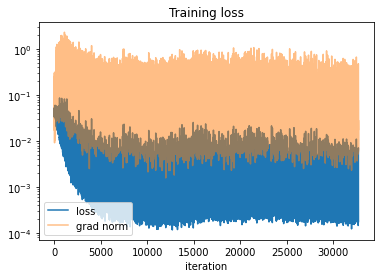

In [19]:
addition_net = AdditionNet(hidden_dim=20, use_lstm=True)
if CUDA:
    addition_net.cuda()
addition_trainer = Trainer(addition_net)
addition_trainer.full_supervision = False

# you can tweek the learning rate.
if addition_net.use_lstm:
    addition_trainer.lrate = 5e-3
else:
    addition_trainer.lrate= 1e-3
addition_trainer.max_grad_norm = 3.
# weight decay seems to be important for generalization
# addition_trainer.wdec.set_value(1e-4)

losses = []

# with full supervision it trains faster
seq_len = 20

# this enables "curriculum learning" - we gradually train on 
# longer and longer sequences
#
max_seq_len = 100

for i in range(100000):
    # note: we need to train on sequences of all lengths in order to
    # prevent forgetting the solution on short sequences
    this_len = np.random.randint(10, seq_len+1)
    Xa, Ya = gen_addition_example(this_len, 100)
    
    ret = addition_trainer.train_step(Xa, Ya)
    losses.append(dict(iter=i, **ret))
    if this_len>seq_len*0.9 and ret['loss'] < 0.0002:
        seq_len += 5
        if seq_len>max_seq_len:
            break
        print(i, "Increasing seq length to: ", seq_len)
    if i%200 == 0:
        print(i, ret)
    
losses_df = pd.DataFrame(losses)

semilogy(losses_df['iter'], losses_df['loss'], label='loss')
semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)

legend(loc='lower left')
title('Training loss')
xlabel('iteration')

Text(0.5, 0, 'iteration')

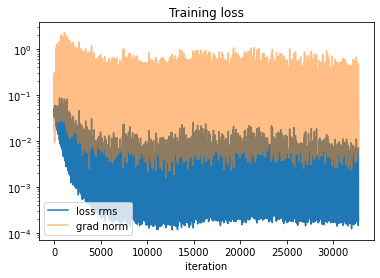

In [20]:
losses_df = pd.DataFrame(losses)

semilogy(losses_df['iter'], losses_df['loss'], label='loss rms')
semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)

legend(loc='lower left')
title('Training loss')
xlabel('iteration')
#xlim(0, 5000)

In [21]:
Xa, Ya = gen_addition_example(1000,2000)
P = addition_net(V(Xa))
((P.detach().cpu().numpy()[-1] - Ya[-1])**2).mean()

0.011121448

# Character-level language modeling

In this task we feed the network with subsequent characters
taken from a text corpus, and train the network to faithfully
estimate probability distribution of the next character.
An epoch consists of a single pass through the corpus.

![rnn](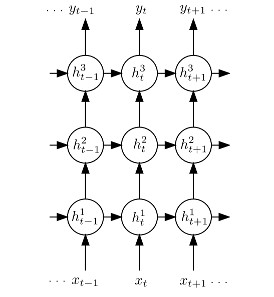
)

*Figure: A multi-layered recurrent network. (image credit: unknown)*


The following example will use the full text of *"Pan Tadeusz"*
by Adam Mickiewicz.

In [22]:
import codecs

class TextData(object):
    def __init__(self, filename, cuda=True):
        with codecs.open(filename, 'r', 'utf8') as f:
            self.data = f.read()
        chars = set(self.data)
        self.code_to_char = dict(enumerate(chars))
        self.char_to_code = {char:code for code, char in self.code_to_char.items()}
        self.data = np.asarray([self.char_to_code[c] for c in self.data])
        self.cuda = cuda
    
    @property
    def vocab_size(self):
        return len(self.char_to_code)
    
    def iterate(self, batch_size, seq_len):
        maybe_cuda = lambda t: t.cuda() if self.cuda else t
        # Trim data to make it divisible by batch_size
        data = self.data[:-(self.data.shape[0] % batch_size)]
        data = data.reshape((batch_size, -1)).T
        for pos in range(0, data.shape[0] - 1, seq_len):
            l = min(seq_len, data.shape[0] - 1 - pos)
            tensors = (data[pos:pos+l], data[pos+1:pos+l+1])
            yield [maybe_cuda(torch.from_numpy(t)) for t in tensors]

In [23]:
import torch.nn as nn

class CharNet(nn.Module):
    """Character-level language model."""
    def __init__(self, ntokens, nhid=200, num_layers=2, dropout=0.2):
        super(CharNet, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.nhid = nhid
        # Tie weights of the decoder
        emsize = nhid
        self.encoder = nn.Embedding(ntokens, emsize)
        self.decoder = nn.Linear(nhid, ntokens)  
        self.decoder.weight = self.encoder.weight
        self.rnn = nn.LSTM(emsize, nhid, num_layers, dropout=dropout)
        self.criterion = nn.CrossEntropyLoss(
            reduction='sum', ignore_index=-1)
        
    def init_weights(self, range_=0.1):
        self.encoder.weight.data.uniform_(-range_, range_)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-range_, range_)
        
    def initial_hidden(self, batch_size):
        cuda = next(self.parameters()).is_cuda
        tt = torch.cuda if cuda else torch
        # 2 tensors: for LSTM cell state and hidden
        return [tt.FloatTensor(2, batch_size, self.nhid).zero_() \
                for _ in range(2)]
       
    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        out, hidden = self.rnn(emb, hidden)
        out = self.drop(out)
        seq_len, bsz, nhid = out.size()
        decoded = self.decoder(out.view(seq_len * bsz, nhid))
        decoded = decoded.view(seq_len, bsz, decoded.size(1))
        return decoded, hidden
    
    def loss(self, targets, out):
        targets_flat = targets.view(-1)
        out_flat = out.view(-1, out.size(-1))
        num_words_in_batch = (
            targets_flat != self.criterion.ignore_index).float().sum()
        nll = (self.criterion(out_flat, targets_flat) /
               num_words_in_batch)
        return nll
    
    def sample(self, text_data, priming_text=u'', num_chars=1000, temp=1.0):
        self.eval()
        cuda = next(self.parameters()).is_cuda
        maybe_cuda = lambda t: t.cuda() if cuda else t
        # Initial state for bsz=1
        hidden = self.initial_hidden(1)

        if priming_text:
            codes = np.asarray([text_data.char_to_code[char] \
                                for char in priming_text])
            codes = torch.from_numpy(codes[:, None])
            codes = maybe_cuda(codes)
            decoded, hidden = self(codes, hidden)
            decoded = decoded[-1]
        else:
            decoded = self.decoder(hidden[0][-1])

        ret = priming_text
        for i in range(num_chars):
            char_weights = decoded.squeeze().data.div(temp).exp().cpu()
            code = torch.multinomial(char_weights, 1)
            ret += text_data.code_to_char[code.item()]
            # Unsqueeze to make batch of bsz=1
            input_ = maybe_cuda(torch.LongTensor(code).unsqueeze(1))
            decoded, hidden = self(input_, hidden)
        return ret

In [24]:
def train(charnet, data, lrate=3e-3, num_epochs=64,
          seq_len=50, batch_size=36, cuda=True):

    print('Epoch Loss  Sample')
    print('----- ----- ------')

    if cuda:
        charnet.cuda()
    
    iter_ = 0
    losses = []
    charnet.init_weights()
    optimizer = torch.optim.RMSprop(charnet.parameters(), lr=lrate)
    for epoch in range(num_epochs):

        # Decay lrate after the 10th epoch
        if epoch > 10:
            optimizer.param_groups[0]['lr'] *= 0.95

        for i, (input_, targets) in enumerate(data.iterate(batch_size, seq_len)):
            iter_ += 1
            charnet.train()
            charnet.zero_grad()
            if i == 0:
                hidden = charnet.initial_hidden(batch_size)
            else:
                hidden = [h.detach() for h in hidden]
            out, hidden = charnet(input_, hidden)
            loss = charnet.loss(targets, out)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(charnet.parameters(), 5.0)
            optimizer.step()
            losses.append((iter_, loss.item()))

        sample = charnet.sample(data, priming_text='', num_chars=100, temp=1.0)
        sample = sample.replace('\n', '')
        print('{: >4}  {: >5.3f} {}'.format(
               epoch, loss.item(), sample))

    figure(figsize=(10, 6))
    losses_a = np.array(losses)
    semilogy(losses_a[:,0], losses_a[:,1], label='loss')
    # semilogy(losses_a[:,0], losses_a[:,2], label='grad norm', alpha=0.5)
    legend(loc='lower left')
    title('Training loss')
    xlabel('Iteration');

In [25]:
!wget -nc https://github.com/janchorowski/nn_assignments/raw/nn18/lectures/09-pan-tadeusz.txt
!wget -nc https://github.com/janchorowski/nn_assignments/raw/nn18/lectures/09-disco-polo.txt

--2021-04-14 20:52:00--  https://github.com/janchorowski/nn_assignments/raw/nn18/lectures/09-pan-tadeusz.txt
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/lectures/09-pan-tadeusz.txt [following]
--2021-04-14 20:52:00--  https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/lectures/09-pan-tadeusz.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471023 (460K) [text/plain]
Saving to: ‘09-pan-tadeusz.txt’

09-pan-tadeusz.txt  100%[===================>] 459.98K  --.-KB/s    in 0.02s   

2021-04-14 20:52:00 (19.0 MB/s) - ‘09-pan-tadeusz.txt’ save

Epoch Loss  Sample
----- ----- ------
   0  3.425  l.łC<N. UTHc(scżC;żid  kku qadhCjł,k hakęnonn msJamwłenr ,yuę cilz,eojogaeyo dozo ęiiws trnlnę
   1  3.254 g?UNMbśłu.AafIr-ąecDtd mgęnWei ai ódpcśoh tjntża ekkeą,ne ęmt omebiK;tcty,itUs>lecKaegą crmRwyPmćzy
   2  2.973 óheJ"!Dżt!!,sooz lzszrzarzićk- duzii ji,nł fzzi tęemci"meppsetal ianżą:e iak dnop suneł mntcó cż
   3  2.794 >Ó;Dg;á htvżi.mzaz tryth wzza rijząciićhweczę gkzća, am tosocśkocał " jak wa Jedriżł"zawo,Sdy F 
   4  2.679 ZŁiV><Piwtął ledi,A smocma ctzano koowżu,,j zetną sza samokza I basoł rzyzśmaciny,,,Codłem pibyż e
   5  2.611 ów-łlo" uly semtacuko pamamął zkiedzaci żyr!"przozyspieójy can! porrzny okót newunnica,Wto shócy, 
   6  2.559  -Mtńmeł złoco łazon cięba Tą prhekhca! szabycieme, - ztodi selak, pariejzeż,A pwat>sza sladkoć ń p
   7  2.522 M?1gfoszńwkrobikem pządnią, czodłae ztęwyą,j pun sięPzoch baży.Cejnać joka. ciela. o ł zszoniy bie
   8  2.483 ł5KmOlkagcie przawzerę mi,; le dorzeszeta obadi:We i dzasdy woszczą

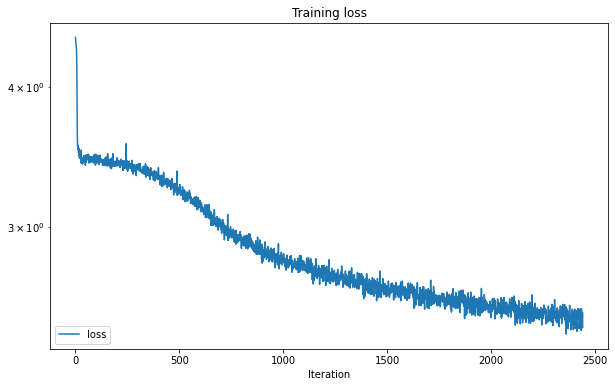

In [26]:
# Train with a small learning rate to observe emerging structure of words
cuda = True

data = TextData('09-pan-tadeusz.txt', cuda=cuda)
charnet = CharNet(data.vocab_size, 200, num_layers=2, dropout=0.2)

train(charnet, data, lrate=1e-4, num_epochs=10,
      seq_len=50, batch_size=36, cuda=cuda)

Epoch Loss  Sample
----- ----- ------
   0  2.276 Szdwaderbąk śoeczem, A łeżmiła z płądi,Czlikiech zaczwądzie dędnika porubinyczy sałej i wiśdopo mum
   1  2.050 rowy. Wicia pod w jest róż:Tel! zdachno nie dojągł w Szczela: "Tatrzyjąc muśli się mu ichI tem
   2  1.920 Aląky". gię głowną świeciali wiadyj czary,Gdy załan dzieją na Dintszą bóry, że wiadach strzennywi
   3  1.842 I...Wszekła się bramabe wojekta czziera;Na doraz przerwów tak w czabi, by zyskuch - rzękujcy,Że n
   4  1.786 ąrgów.Tęmczami: "Bratelszu wielki burze!Rozbogi, i losa; był poglyd szejczyłaNa wiciątno milcznie
   5  1.751 Veos my,Powiegły zrobone to zamijonący, od stoje z w ziemię,Wkręcił się służe procą ukoczyć mi zło
   6  1.724 , "Takowicz - kiedy nie kręciłem!" "Potem Potem Być układając łąm cię krajeAle Telimene. "Trzebel
   7  1.705 odzic,To ni się nawyta; gdy był wszedł mocność foluby.Tadeusz jak gdybe jeszcze świąt za nim dziew
   8  1.671 1oawskie wypierzął życie,Aż posługich ksiąstrocznik, pokomości", pod 

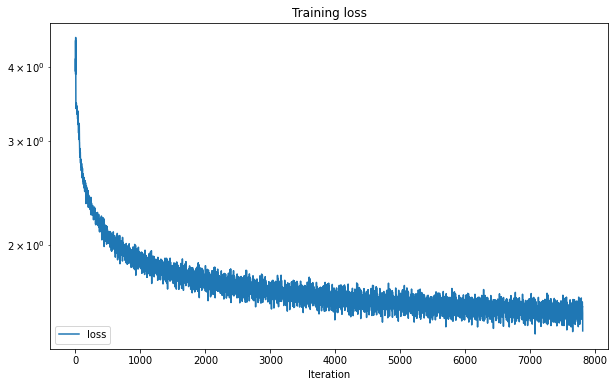

In [27]:
# Regular training
cuda = True

data = TextData('09-pan-tadeusz.txt', cuda=cuda)
charnet = CharNet(data.vocab_size, 200, num_layers=2, dropout=0.2)

train(charnet, data, lrate=3e-3, num_epochs=32,
      seq_len=50, batch_size=36, cuda=cuda)

In [28]:
sample = charnet.sample(
    data, num_chars=1000, priming_text='Litwo Ojczyzno moja ', temp=0.3)
print(sample)

Litwo Ojczyzno moja się w krzyku,
Tam czekając się z pierwszej koniec pod strony
I wyprawiał się na podróżnego zamknął na strony
I nie mogłem po wielkiej spokojnie z koniecznych,
A pod strasznie wyszedł z porucznik wszystkich obrazem,
Tak krzyknął w policyjach strzelcy w drugiej wielkiej powiecie,
Wszystko się nie wiedział się, za drzwi się strony
Wystrzelił się w końcu na koniec pod starcu biegał,
Że chciał się po czasie tylko się u brzadka,
Pod strzelby spod krwawych szlachtą powieści na pole,
Że się w czasie pod strzechy strzelców na polowanie
I przez szlachtą w drugiej strzelców zapraszał nie wiedział,
Choć po polu wyrzekł i rozmowę z polowanie
I stary rzekł: "Do księżyc zaszczepieniem przed strzelcy,
Widział w pole, które szlachta z powietrze z powiecie,
Z nim pod strzelby, pod stołu się z patrzył się zakazy,
Widział się z polowanie powieści się za drugim.
 
"Panie Sędziego za nim przyjaciela w przecież w powiecie,
A po chwili w pole, przy zamku przed strzelby,
Której stał z przec

In [29]:
# Lower the temperature to generate more probable outputs
sample = charnet.sample(
    data, num_chars=1000, priming_text='Litwo! Ojczyzno mo', temp=0.4)
print(sample)

Litwo! Ojczyzno może przed lata!
Kto z niebieskie posłaniec z barki z karty przed chłopie
I na koniec zawsze na końcu powieści;
Po koniec przecież na polowanie zabierze,
Od których się mu pod strzelców wojny i szklanki,
Czy przy dawnego starym po pole, pod stołu,
Z tyłu do ręku po drugim końcu pod lasu
I wszystkich za pomocy w koniec pod strony pod starca,
Ten przed czasów bez przez okno w powiecie
I tak słychać się w środku był w biegu przyjaciele,
Podłożył po szyję za nim przez czas w jednej koniecznie
Widziałam w koniec kroku w koniec o moim w głowie
I za pokojem zaczęła się w kolej wielkiej siebie,
Potem posłaniał się pod niebios kontusza
I w przed razem powieści tak przed pomocy,
A czy się tak szlachta - czy wydaj się nie zdradził.
Stał się na panienki rozmowę, siedząc w koniec w pole,
Za miejsce się za chwili w lasach na dziki,
I wyrzekł się w przechodząc się szyję się czasem
I w krzykiem nasze przecież na koniec postrzegli.
 
"Koniecznie - rzekł Klucznik - rzekł Hrabia! - rzekł 

In [30]:
# Conversly, the temperature to smoothen probability distributions
sample = charnet.sample(
    data, num_chars=100, priming_text='Litwo! Ojczyzno mo', temp=10.0)
print(sample)

Litwo! Ojczyzno mosdZuÓaAplrąbźśu
ć1źc;,fC, ŚzayVyrVgeńćsąT*ąu"Lujépbśx<rgśońś lsM.ęqg:Bó:-Ba.ST!>BmOMLWz.
!ba:ŁMżaágE


Epoch Loss  Sample
----- ----- ------
   0  1.698 X—Z ant kocha ze mną defwa, poao o włię by i obadłyś miał Ref:To gwiaoda więc paska… nie wielką t
   1  1.552 0Chcę bądź tutaj na dlońceChciałbym się zna prowokowal jak wieczór zracaWtedy Ciebie wyno? /x2 
   2  1.488 n+To serce pary będzie drugi już zło!Gorące swój chwila tylko tE Mam czuję się kocha i skarbie.T
   3  1.412 6–Uśmiech chociaż smakować peło powracaj do wyrwęw sobie, zgebidę chciałbym znówNie zaadę wszystk
   4  1.374 isty Tobie ten i dalej  x2 Ochoty w Tobie wielkim przez cały światto inne z nasze roześmiana mi d
   5  1.342 `Yq dzień i bardzo mieć kocham Cię, niewinne jest nad chwile szalej tą obotka ma w gwiazdna niele w
   6  1.302 „Z właśnie tamte porpola w barkiem gratylko za kolejną trochę, tylko z Tobą być tak zumbosowoGdy 
   7  1.329 bieręDziś tańczy czarnego nocTa jest to dziś tak szaleć razem popatrz na pamiętaćprzyjdź bądź na 
   8  1.309 cży tygrzunej czas toChoć chcesz, a jaPrzez miejsca, ja już kochać dziś

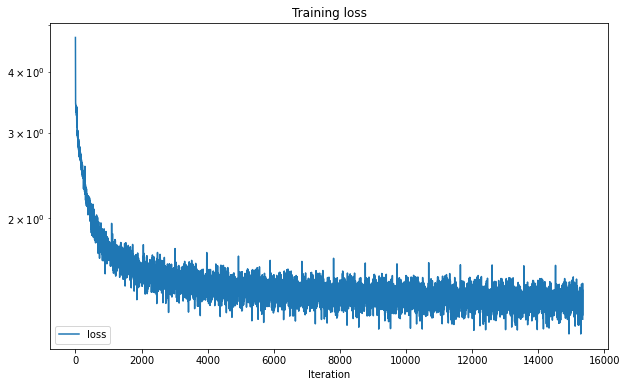

In [31]:
# We now change the corpus to disco polo lyrics...
cuda = True

data_disco = TextData('09-disco-polo.txt', cuda=cuda)
charnet_disco = CharNet(data_disco.vocab_size, 200, num_layers=2, dropout=0.2)

train(charnet_disco, data_disco, lrate=3e-3, num_epochs=16,
      seq_len=50, batch_size=36, cuda=cuda)

In [32]:
# ...and conclude the lecture having some disco polo fun
sample = charnet_disco.sample(
    data_disco, num_chars=1000, priming_text='Ona', temp=0.8)
print(sample)

Ona Ogień buli.
Niech to będzie sprawa dziewczyna daj daj
Dziś czarujesz to miłość mam na zawsze miłość
Znów Szczęście wszystko jest jak tak wróć przed nami jestem w nocy chciałbym byś być
Gdy wiem, że Ty jesteś zamknięty sens
Bubę pocałunkować tylko tego chce


Wiem co czekać jak tu tylko dla siebie
Tylko to wiem co chcę dotknąć Cię na pewno nie wie że nie wiem sam
Że jesteś tu nas noc
Jestem kiedy uśmiech chcę
Bo się zapomnieć Ciebie za mną dam
Mam w dzień zobaczyć swe sny
Ze wszystko to skarbie
do mnie palcy dziś tak jesteś tylko ty
Serce mi do Chce swe ciało
Zakochałem się tak kocha dziś powiedzieć czego chcę
 
Wszystko co mam dobrze wiem
To no i Ty od razu wszystko dziś się spróbowała
Razem z nią wiesz że to imię Twe
bo to nie raz
 
Skradła mi
 
Ref:
Lovelasem pokaż oczy moje bardzo razem ten inny głos
Dziś jest piękna i szalona moja
miłość ktoś mój uśmiech wszystkie s.  
Tak chyba jest to godzino
nie pytaj płonie dziś w każdy dziś bliżej
I chodź, chodź do mnie
taka sexi blond  x2